In [33]:
#Importing Libraries
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests
import sqlparse
import seaborn as sns

In [34]:
warnings.filterwarnings('ignore')

In [35]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    
    colnames = [desc[0] for desc in cur.description]
    conn.close()
    return pd.DataFrame(data, columns=colnames)

In [36]:
#Three Wikipedia Languages
wikis = ['tewiki', 'hiwiki', 'mlwiki']

Visualizing number of Deleted pages in Wikimedia from Multiple wikipedia language sets (tewiki , hiwiki , mlwiki)

In [37]:
#Fetching the SQL query from Github
query_url1 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_deleted_pages_and_edits.sql"
query1 = requests.get(query_url1).text

In [38]:
#Fetched SQL Query
query1

'SELECT\n    DATE(ar_timestamp) AS Deletion_Date,             -- Extracts the date for dashboard filtering\n    COUNT(ar_id) AS deleted_pages                    -- Counts the number of deleted pages per day\nFROM\n    archive                                          -- Table containing records of deleted pages\nGROUP BY\n    Deletion_Date                                    -- Groups the counts by day\nORDER BY\n    Deletion_Date;                                   -- Sorts the results by date\n'

Querying: tewiki
Querying: hiwiki
Querying: mlwiki


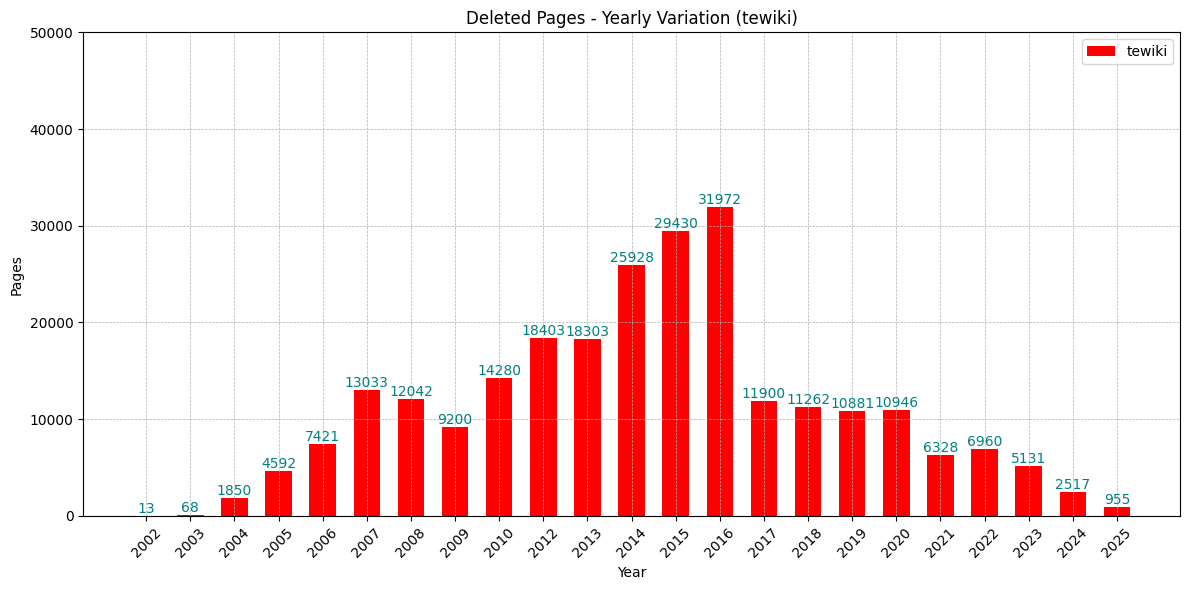

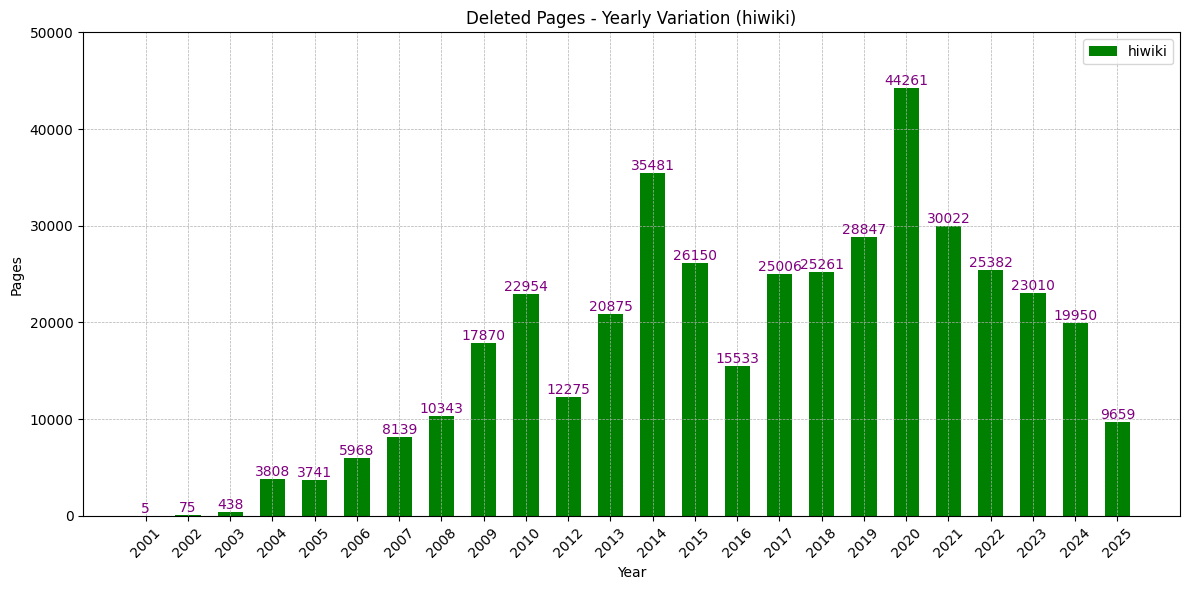

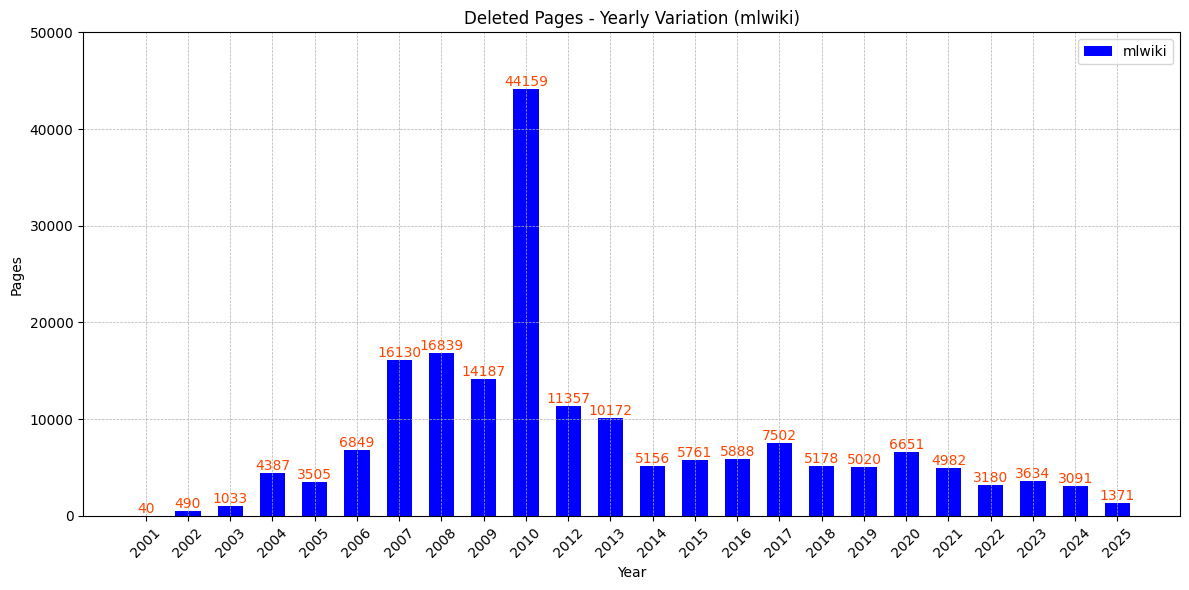

In [39]:
# Labels to display in each plot
Labels = ["tewiki", "hiwiki", "mlwiki"]
# Setting colours for bar plots
color_line = ["red", "green", "blue"]
# Setting colours for values of each bar label
color_dot = ['teal', 'purple', 'orangered']

# Resampling the data to Yearly based Category
yearly_data = []
for wiki in wikis:
    print(f"Querying: {wiki}")
    try:
        df = connect_and_query(wiki, query1)
        # Converting into datetime format
        df['Deletion_Date'] = pd.to_datetime(df['Deletion_Date'])
        df.set_index('Deletion_Date', inplace=True)
        yearly = df['deleted_pages'].resample('YE').sum()
        yearly_data.append(yearly)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# Manually remove 2011 data for all wiki
for i in range(3):
    yearly_data[i] = yearly_data[i][yearly_data[i].index.year != 2011]

# Performing Visualization for each wiki (Yearly Variation) using Bar Chart
for yearly, label, bar_color, text_color in zip(yearly_data, Labels, color_line, color_dot):
    plt.figure(figsize=(12, 6))
    years = [d.year for d in yearly.index]
    positions = range(len(years))  # x-axis positions
    #Use plt.bar for Bar Chart
    plt.bar(positions, yearly, color=bar_color, label=label, width=0.6)
    # Add text labels
    for pos, value in zip(positions, yearly):
        plt.text(pos, value, str(int(value)), fontsize=10, ha="center", va="bottom", rotation=0, color=text_color)

    plt.title(f'Deleted Pages - Yearly Variation ({label})')
    plt.xlabel('Year')
    plt.ylabel('Pages')
    plt.ylim(0, 50000)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(ticks=positions, labels=years, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


Visualizing number of Automated Edits done in Wikimedia from Multiple wikipedia language sets (tewiki , hiwiki , mlwiki)


In [40]:
#Fetching the SQL query from Github
query_url2 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_Automated_Edits.sql"
query2 = requests.get(query_url2).text

In [41]:
#Fetched SQL Query
query2

"SELECT\n    DATE(r.rev_timestamp) AS Edit_Date,              -- Extract the date for filtering on the dashboard\n    COUNT(DISTINCT r.rev_id) AS Automated_Edits      -- Count distinct edits to avoid duplicates\nFROM\n    revision AS r\nJOIN\n    actor AS a ON r.rev_actor = a.actor_id           -- Join to identify the editor (actor)\nJOIN\n    user_groups AS ug ON a.actor_user = ug.ug_user   -- Join to access user group information\nWHERE\n    ug.ug_group = 'bot'                              -- Filter for edits made only by bots\nGROUP BY\n    Edit_Date                                        -- Group results by date\nORDER BY\n    Edit_Date;                                       -- Sort the results chronologically\n"

Querying: tewiki
Querying: hiwiki
Querying: mlwiki


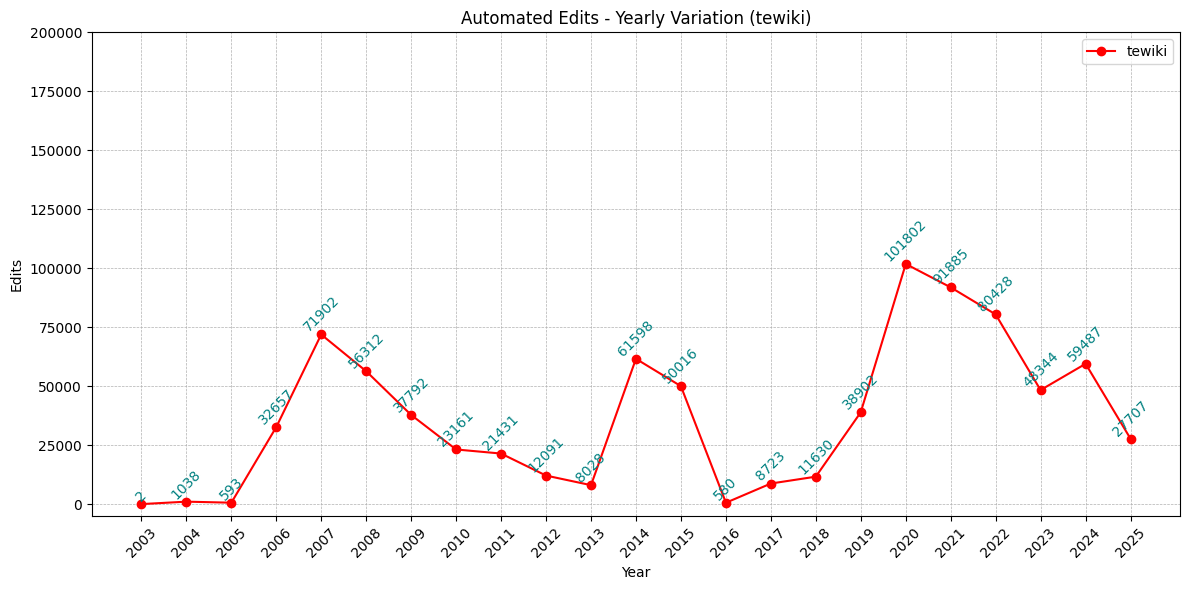

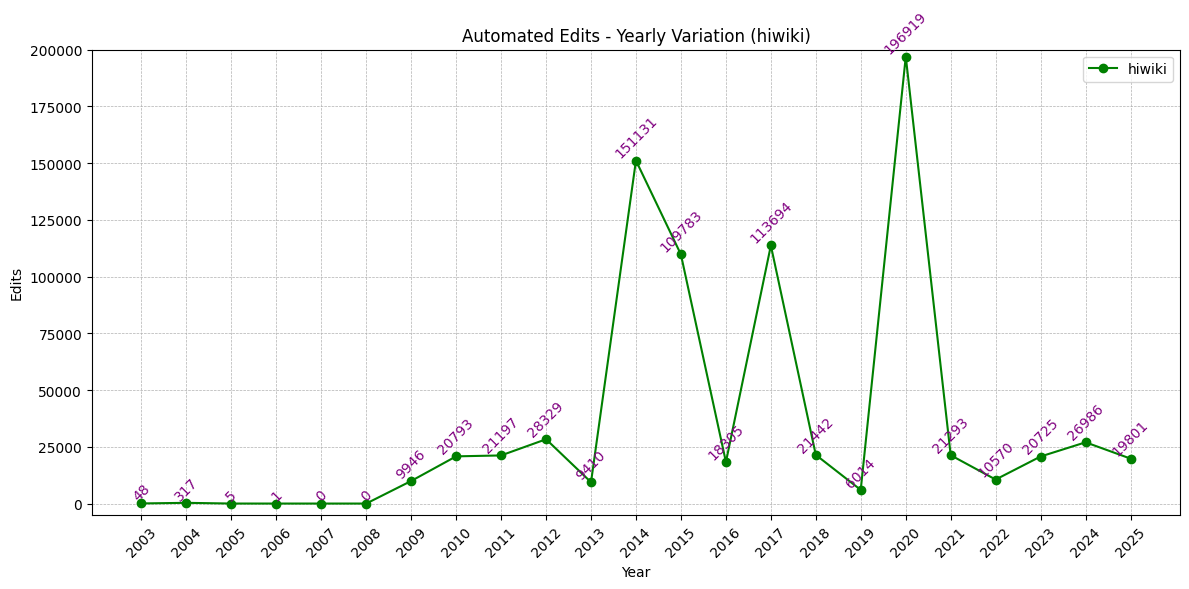

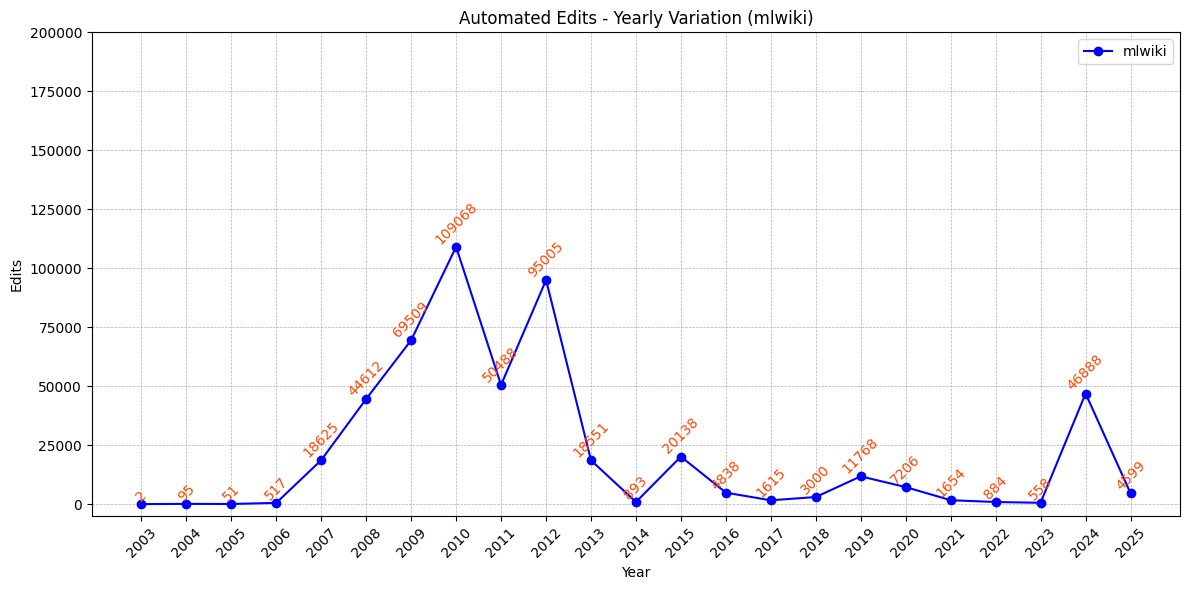

In [42]:
# Labels to display in each plot
Labels = ["tewiki", "hiwiki", "mlwiki"]
# Setting colours for bar plots
color_line = ["red", "green", "blue"]
# Setting colours for values of each bar label
color_dot = ['teal', 'purple', 'orangered']

# Resampling the data to Yearly based Category
yearly_data = []
for wiki in wikis:
    print(f"Querying: {wiki}")
    try:
        df = connect_and_query(wiki, query2)
        # Converting into datetime format
        df['Edit_Date'] = pd.to_datetime(df['Edit_Date'])  
        df.set_index('Edit_Date', inplace=True)
        yearly = df['Automated_Edits'].resample('YE').sum()
        yearly_data.append(yearly)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# Performing Visualization for each wiki (Yearly Variation) using Line Chart
for yearly,label,color,colour in zip(yearly_data,Labels,color_line,color_dot):
  plt.figure(figsize=(12,6))
  # Use plt.plot for Line Chart
  plt.plot(yearly.index,yearly,marker='o',color=color,label=label)
  # Add text labels above bars
  for x,y in zip(yearly.index,yearly):
    plt.text(x,y,str(int(y)),fontsize=10,ha="center",va="bottom",rotation=45,color=colour)
  plt.title(f'Automated Edits - Yearly Variation ({label})')
  plt.xlabel('Year')
  plt.ylabel('Edits')
  plt.ylim(-5000, 200000)
  plt.grid(True, linestyle='--', linewidth=0.5)
  plt.xticks(ticks=yearly.index, labels=[d.year for d in yearly.index], rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()



Visualizing number of Edits revert,rollback,undo in Wikimedia from Multiple wikipedia language sets (tewiki , hiwiki , mlwiki)


In [43]:
#Fetching the SQL query from Github
query_url3 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_edits_deleted,reverted_or_rollback.sql"
query3 = requests.get(query_url3).text

In [44]:
#Fetched SQL Query
query3

"SELECT\n    DATE(r.rev_timestamp) AS Edit_Date,              -- Extracts the date for dashboard filtering\n    COUNT(DISTINCT r.rev_id) AS reverted_edits       -- Counts the number of unique reverted edits\nFROM\n    revision AS r\nJOIN\n    change_tag AS ct ON r.rev_id = ct.ct_rev_id      -- Links revisions to their associated tags\nJOIN\n    change_tag_def AS ctd ON ct.ct_tag_id = ctd.ctd_id -- Gets the name of the tag\nWHERE\n    ctd.ctd_name IN ('mw-reverted', 'mw-rollback', 'mw-undo') -- Filters for specific revert, rollback, and undo tags\nGROUP BY\n    Edit_Date                                        -- Groups the daily counts\nORDER BY\n    Edit_Date;                                       -- Sorts the results chronologically\n"

Querying: tewiki
Querying: hiwiki
Querying: mlwiki


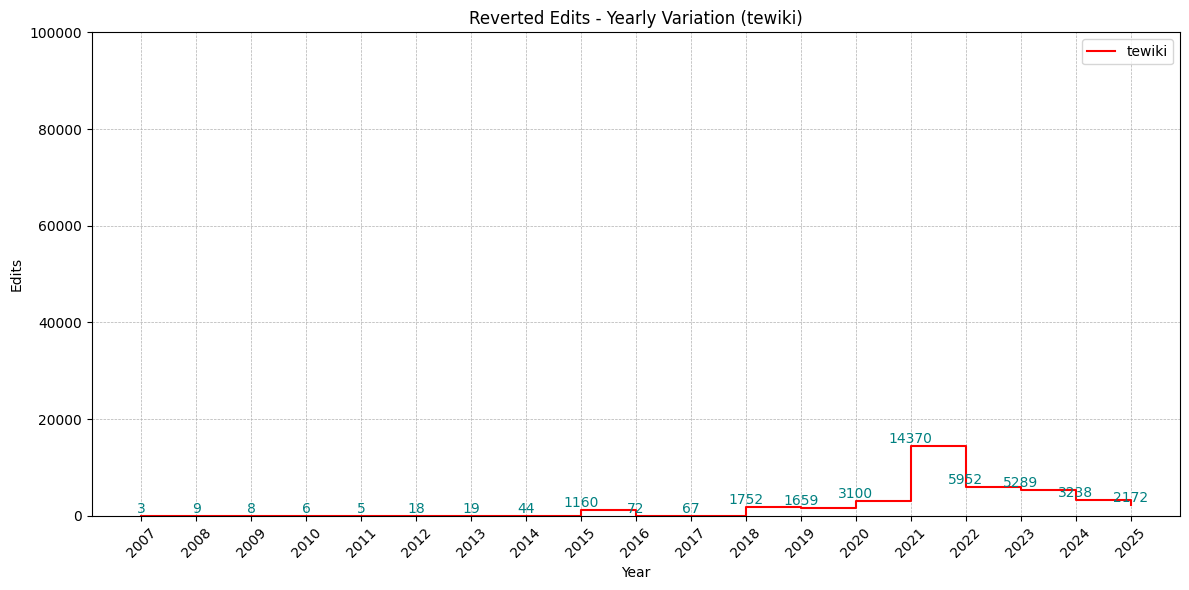

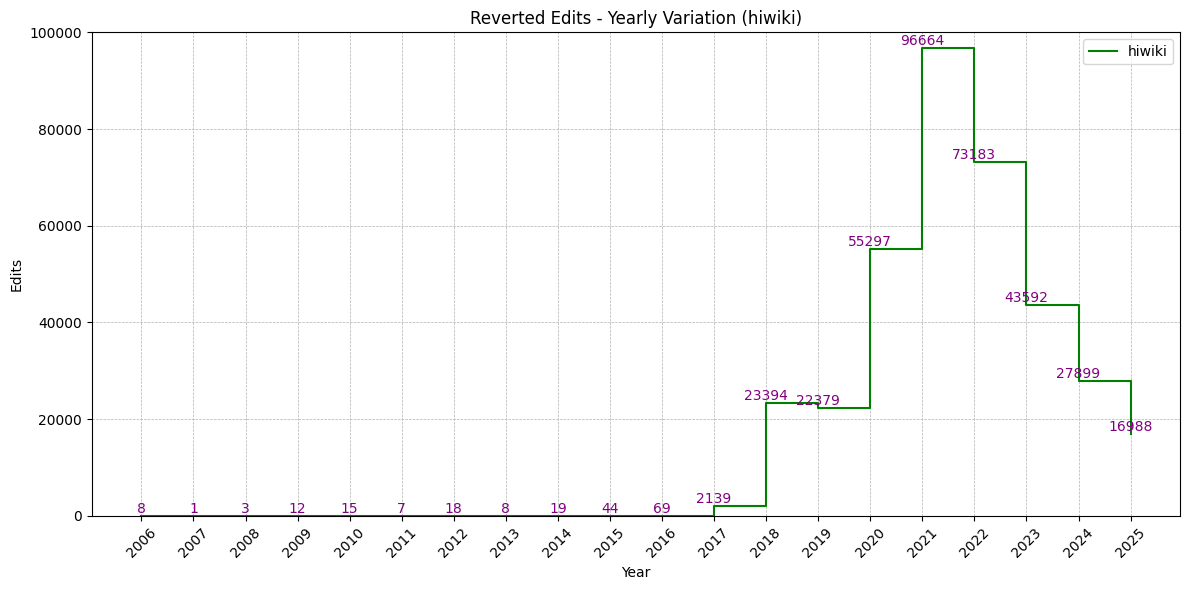

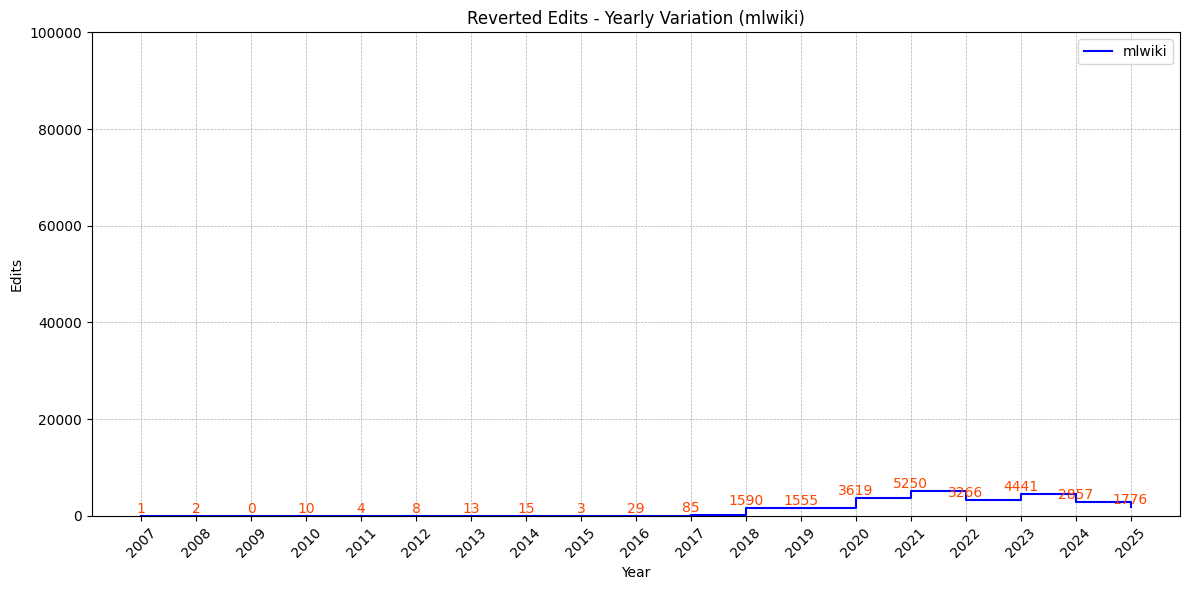

In [45]:
# Labels to display in each plot
Labels = ["tewiki", "hiwiki", "mlwiki"]
# Setting colours for bar plots
color_line = ["red", "green", "blue"]
# Setting colours for values of each bar label
color_dot = ['teal', 'purple', 'orangered']

# Resampling the data to Yearly based Category
yearly_data = []
for wiki in wikis:
    print(f"Querying: {wiki}")
    try:
        df = connect_and_query(wiki, query3)
        # Converting into datetime format
        df['Edit_Date'] = pd.to_datetime(df['Edit_Date'])
        df.set_index('Edit_Date', inplace=True)
        yearly = df['reverted_edits'].resample('YE').sum()
        yearly_data.append(yearly)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# Performing Visualization for each wiki (Yearly Variation) using Step Chart
for yearly, label, color , colour in zip(yearly_data, Labels, color_line ,color_dot):
    plt.figure(figsize=(12, 6))
    # Use plt.step for step chart
    plt.step(yearly.index, yearly, where='post', color=color, label=label)
    # Add text labels above steps
    for x, y in zip(yearly.index, yearly):
        plt.text(x, y, str(int(y)), fontsize=10, ha="center", va="bottom", rotation=0, color=colour)
    plt.title(f'Reverted Edits - Yearly Variation ({label})')
    plt.xlabel('Year')
    plt.ylabel('Edits')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.ylim(0, 100000)
    plt.xticks(ticks=yearly.index, labels=[d.year for d in yearly.index], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()